<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance4_Equipo2_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

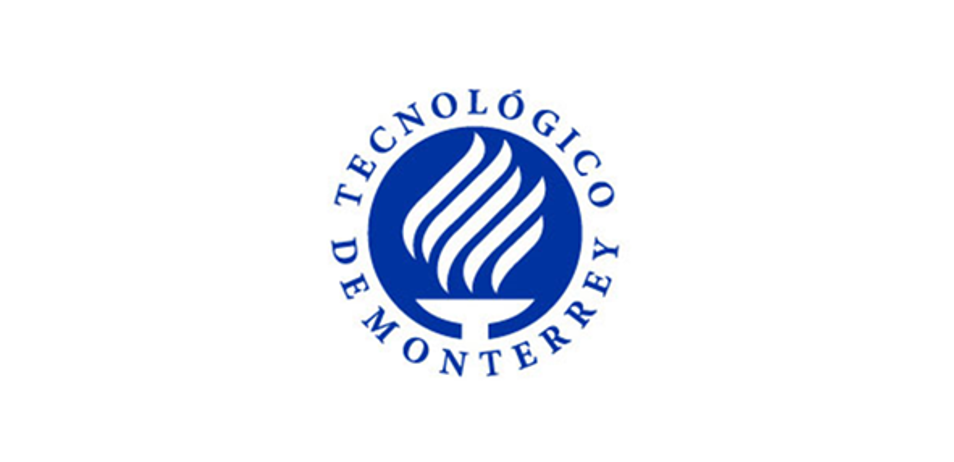

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

###Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



###Prof. Titulares:
###Dra. Grettel Barceló Alonso
###Dr. Luis Eduardo Falcón Morales



###Avance 4. Otros Modelos.



###EQUIPO 2
###Alumnos - Matrícula
###**Matthias Sibrian Illescas - A01794249**
###**José Ramiro Adán Charles - A00174646**
###**Genaro Ramos Higuera - A00351269**

###Instalamos librerias de trabajo

In [1]:
!pip install haystack-ai
!pip install "sentence-transformers>=2.2.0"
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.5/319.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)

Cargamos librerias y definimos los metodos para cargar en memoria los documentos y la conversion de los PDFs

In [1]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["application/pdf"])
pdf_converter = PyPDFToDocument()


Definimos el metodo para limpiar los documentos

In [2]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=50)


Agregamos el embedder que utilizaremos en el Pipeline para los documentos que escribiremos en la document store.

In [3]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)


Ahora armamos la secuencia del Pipeline a aplicar a los documentos PDF

In [4]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


Ahora conectamos el Pipeline:

In [5]:
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("pypdf_converter", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - pypdf_converter: PyPDFToDocument
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - pypdf_converter.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

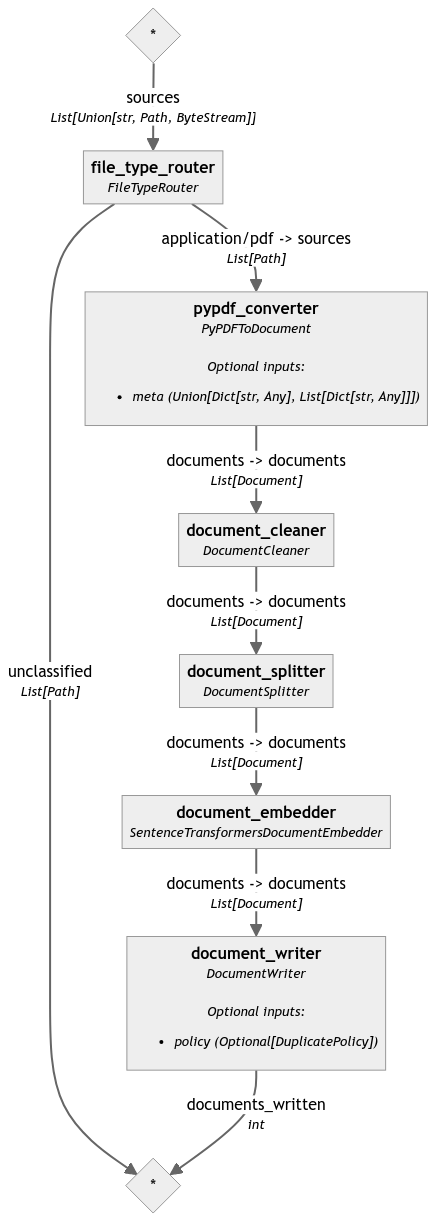

In [6]:
preprocessing_pipeline.show()

###Cargamos todos los documentos de la carpeta de PDFs /content/data/pdf
###y aplicamos el Pipeline de preprocesamiento

In [7]:
from pathlib import Path

carpeta_pdfs = "/content/data/pdf"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(carpeta_pdfs).glob("**/*"))}})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/149 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 4756}}

Ahora utilizaremos el mismo embedder para las preguntas (questions) y poder hacer la recuperacion mediante el Retriever.

In [8]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


In [9]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)


Ahora definimos el prompt builder para las preguntas y le decimos que tome el contexto de los documentos para generar las respuestas

In [10]:
from haystack.components.builders import PromptBuilder
#Given the following information, answer the question.
template = """
Create a concise and informative answer for a given question based solely on the given documents.
You must only use information from the given documents and cite the documents you used by mentioning
their file or document name in the answers.
For example, finish your answer with "Como se menciona en el documento: "

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


Ahora cargamos el API Key para el LLM que utilizaremos:

In [11]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")


Enter OpenAI API key:··········


In [12]:
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [13]:
basic_rag_pipeline = Pipeline()
# Adicionamos los componentes al pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Ahora los conectamos dentro del pipeline
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

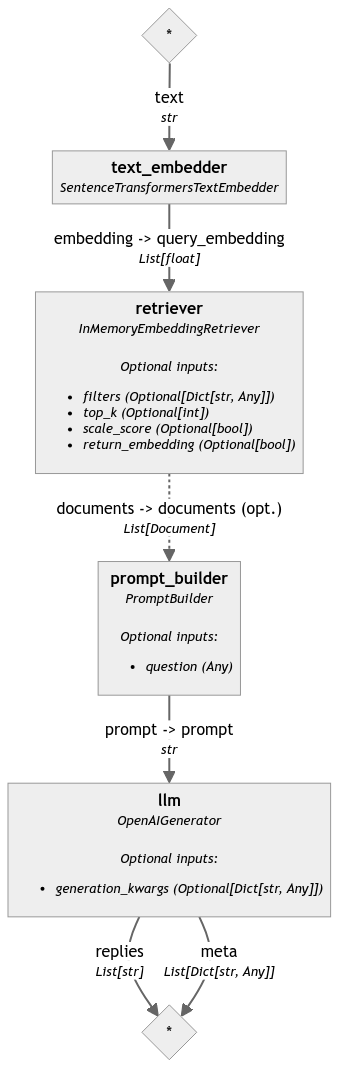

In [14]:
basic_rag_pipeline.show()

## Ahora haremos las siguientes preguntas al LLM y que se base en el contexcto de documentos

1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?
2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?
3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?
4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?
5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?
6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?
7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?
8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?
9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?
10. ¿Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?
11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?
12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?
13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?
14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?

In [15]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada en los documentos, en nuestra institución un crédito académico se define de la siguiente manera:
- Preparatoria: 3 créditos académicos equivalen a 6 unidades académicas.
- Profesional: 3 créditos académicos equivalen a 8 unidades académicas.
- Posgrado: 3 créditos académicos equivalen a 12 unidades académicas. 
Como se menciona en el documento: "Homologación en la unidad de medición de carga académica"


In [17]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina en base a la suma de las horas clase y las horas de trabajo independiente. Por ejemplo, en el caso de tres créditos académicos, esto equivale a 120 horas de trabajo. (Documento: POLÍTICAS Y NORMAS ACADÉMICAS GENERALES) Como se menciona en el documento: "a la suma de las horas clase y las horas de trabajo independiente de tres créditos académicos (120 horas)".


In [18]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales establecidas por la Dirección de Internacionalización y publicadas en el Reglamento para la Gestión y Operación de Programas Internacionales, aplicable según el nivel de estudios (Documento: Normativas académicas generales - Artículo 164 y Normativas académicas generales - Artículo 153). También se menciona que los convenios de cooperación académica internacional son administrados, revisados y autorizados por la Dirección de Internacionalización, y se incluyen lineamientos para la modificación o cancelación de un convenio (Documento: Normativas académicas generales - Artículo 165). Como se menciona en los documentos mencionados.


In [19]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas internacionales establecidas por la Institución, la Dirección de Internacionalización y la Vicerrectoría de Internacionalización para la asignación de créditos académicos en programas internacionales. Como se menciona en el documento "Normas Relacionadas con Programas Internacionales".


In [20]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas se aseguran mediante la definición de la carga académica de tiempo completo para estudiantes por periodo regular, que es de 8 créditos con posibilidad de 2 créditos de sobrecarga. Además, se establecen los requisitos específicos de unidades de formación para programas de especialidades, maestrías y doctorados, asegurando que el total de créditos académicos sea similar entre los diferentes niveles de estudio (Documento: Actualización de créditos y estructura de Programas de Posgrado).

Como se menciona en el documento: "Actualización de créditos y estructura de Programas de Posgrado".


In [21]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante se calcula en función del tiempo dedicado a la unidad de formación para cumplir con los objetivos del curso. En el documento "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES", se menciona que los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno. Además, para los programas de salud con actividades clínicas, la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana. Como se menciona en el documento: "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES".


In [22]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, la carga de trabajo fuera del aula, como tareas y proyectos, también se considera al asignar créditos. Según el documento "CORREO OFICIAL No. 08 – 751 24 de", los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno. Además, se establece que la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana, lo cual incluye actividades fuera del aula. Como se menciona en el documento "CORREO OFICIAL No. 08 – 751 24 de" y en "CORREO OFICIAL No. 08 – 751 24 de".


In [23]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición de crédito académico en posgrado, que incluye 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, sumando un total de 54 horas durante el periodo académico. Además, se establece que cada unidad de formación tiene 2 créditos y que la carga académica de tiempo completo varía según el periodo académico regular o intensivo (Documento: ASUNTO: Actualización de créditos y estructura de Programas de Posgrado). Como se menciona en el documento: "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado".


In [24]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza mediante la inclusión de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey en todos los convenios internacionales (Documento: "Convenios de cooperación académica internacional"). Además, se establecen criterios claros de calificación y carga académica para los alumnos que participen en programas internacionales, asegurando que la asignación de calificaciones se realice de manera adecuada (Documento: "Programas internacionales en modalidad mixta"). Como se menciona en el documento: "Convenios de cooperación académica internacional" y "Programas internacionales en modalidad mixta".


In [25]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para la transferencia de créditos de otras instituciones al Tecnológico de Monterrey, se debe mostrar la equivalencia de unidades por semestre utilizadas en la institución de origen con el concepto de horas-crédito por semestre del Tecnológico de Monterrey. Esto se calcula dividiendo el total de unidades del curso entre cuatro. Además, se debe cumplir con los estándares establecidos de dedicación por crédito, donde la carga académica de tiempo completo por periodo regular es de 8 créditos, con la posibilidad de una sobrecarga de hasta 2 créditos. La decisión final de la equivalencia y transferencia de créditos se realiza a través de las políticas y procedimientos establecidos por la institución. (Archivo Documento de Políticas y Normas Académicas Generales) Como se menciona en el documento de Políticas y Normas Académicas Generales:  y en POLÍTICAS Y NORMAS ACADÉMICAS GENERALES.


In [26]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos son determinantes en el progreso y la planificación académica de los estudiantes, ya que representan el tiempo dedicado a una materia o unidad de formación, tanto en el aula como fuera de ella para lograr los objetivos de aprendizaje (documento "Y PROFESIONAL"). Esto es crucial para asegurar que el total de créditos en un semestre de un plan de estudios sea similar en todos los niveles educativos, desde preparatoria hasta posgrado (documento sin nombre). Además, la definición de créditos académicos varía según el nivel educativo, con equivalencias específicas para cada uno, lo que impacta en la carga académica y en la estructura de los programas de estudios (documentos "ASUNTO: Homologación en la unidad de medición de carga académica" y "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado"). Esto se refleja en la necesidad de cumplir con estándares establecidos de dedicación por crédito en cursos intensivos y en la distribución de créditos po

In [27]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan regularmente, como se menciona en el documento "Homologación en la unidad de medición de carga académica" donde se informa sobre la transición gradual hacia la unidad de medida de Créditos Académicos en diferentes niveles educativos a partir de ciertas fechas específicas. Esta actualización se llevará a cabo de manera progresiva en todos los programas académicos. Como se menciona en el documento: "Homologación en la unidad de medición de carga académica".


In [28]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como el número de créditos reprobados y el promedio mínimo requerido para la conservación de la beca en el programa académico (Archivo: Reglamento_Academico). Como se menciona en el documento: "Se calculará de acuerdo al total de créditos académicos reprobados en el periodo" (Archivo: Reglamento_Academico).


In [29]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según el documento "Actualización de créditos y estructura de Programas de Posgrado", la distribución de horas en el cálculo de un crédito académico es de 15 horas de sesiones con el profesor y 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico. Como se menciona en el documento "Actualización de créditos y estructura de Programas de Posgrado":


## Ahora probamos con el LLM Mistral mistralai/Mixtral-8x7B-Instruct-v0.1

In [30]:
from haystack.components.generators import HuggingFaceAPIGenerator

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")

Enter Hugging Face token:··········


In [31]:

generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"})

In [32]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

En nuestra institución, un crédito académico se define de la siguiente manera para los 3 niveles educativos:

- Preparatoria: 3 créditos académicos equivalen a 6 unidades académicas. (Documento: "Homologación en la unidad de medición de carga académica")

- Profesional: 3 créditos académicos equivalen a 8 unidades académicas. (Documento: "Homologación en la unidad de medición de carga académica")

- Posgrado: 3 créditos académicos equivalen a 12 unidades académicas. (Documento: "Homologación en la unidad de medición de carga académica")

Como se menciona en el documento: "Homologación en la unidad de medición de carga académica"


In [33]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina de la siguiente manera: un crédito académico equivale a 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico (Documento "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado"). Como se menciona en el documento: "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado".


In [34]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales e internacionales establecidas en el Reglamento para la Gestión y Operación de Programas Internacionales, el cual es aplicable de acuerdo al nivel de estudios. Este reglamento, establecido por la Dirección de Internacionalización, incluye lineamientos para la asignación de créditos académicos en programas internacionales, tanto para los alumnos del Tecnológico de Monterrey como para los alumnos extranjeros que participen en dichos programas (Documento: "Programas Internacionales del Tecnológico de Monterrey" - Artículo 164). Como se menciona en el documento: "CAPÍTULO VIII Normas Relacionadas con Programas Internacionales".


In [35]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales para la asignación de créditos académicos, establecidas por la Dirección de Internacionalización y publicadas en el Reglamento para la Gestión y Operación de Programas Internacionales (Archivo: Normas Académicas Generales). Como se menciona en el documento: "Los convenios de cooperación académica internacional son administrados, revisados y autorizados por la Dirección de Internacionalización" y "Los lineamientos y requisitos para realizar convenios de cooperación académica internacional son establecidos por la Dirección de Internacionalización".


In [36]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos se aseguran a través de la definición de un crédito académico consistente en 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, totalizando 54 horas por periodo académico (Documento: ASUNTO : Actualización de créditos y estructura de Programas de Posgrado). Además, se establecen unidades de formación de 2 créditos cada una para garantizar la equivalencia en todas las unidades de formación entre los programas de profesional, maestría y doctorado (Documento: Actualización de créditos y estructura de Programas de Posgrado). Este proceso es responsabilidad de las Escuelas y de los departamentos académicos, así como de la Dirección de Posgrados y la Vicerrectoría de Innovación Educativa y Normatividad Académica (Documento: Actualización de créditos y estructura de Programas de Posgrado). Como se menciona en el documento: ASUNTO : Actualización de créditos y estructura de Programas de 

In [37]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula asignando un determinado número de créditos académicos a cada unidad de formación, basado en el tiempo de trabajo que un alumno dedica a la unidad de formación para cumplir con los objetivos del mismo. Este tiempo de trabajo incluye tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno. Esta asignación de créditos académicos se realiza de manera que el total de créditos en las unidades de formación que integran un semestre de un plan de estudios sea similar en diferentes programas académicos (Documento: Políticas y Normas Académicas Generales). Como se menciona en el documento: "Los créditos académicos de una unidad de formación representan el tiempo de trabajo que un alumno dedica a la unidad de formación para cumplir con los objetivos del mismo."


In [38]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, la asignación de créditos también considera la carga de trabajo fuera del aula, como tareas y proyectos, para cumplir con los objetivos de la unidad de formación (Documento: "Artículo 79"). Como se menciona en el documento: "Los créditos académicos de una unidad de formación representan el tiempo de trabajo que un alumno dedica a la unidad de formación para cumplir con los objetivos del mismo."


In [39]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición de un crédito académico, que incluye 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, sumando un total de 54 horas durante el periodo académico (ASUNTO : Actualización de créditos y estructura de Programas de Posgrado). Además, se establece que cada unidad de formación tiene asignados 2 créditos (ASUNTO : Actualización de créditos y estructura de Programas de Posgrado). Esta información se encuentra detallada en los documentos sobre la actualización de créditos y estructura de Programas de Posgrado. Como se menciona en el documento: "ASUNTO : Actualización de créditos y estructura de Programas de Posgrado" y "A cada unidad de formación se asignará un determinado número de créditos académicos."


In [40]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional a través de la inclusión de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey, según lo establecido en los convenios correspondientes (Archivo: "582"). Además, la Vicerrectoría Asociada de Internacionalización establece los lineamientos y requisitos para realizar convenios de cooperación académica internacional, asegurando la calidad y reconocimiento de los créditos académicos (Archivo: "592").Como se menciona en el documento: "582" y "592".


In [41]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones consiste en que las horas de trabajo correspondientes a los cursos pueden estimarse en horas-crédito por semestre, de acuerdo con ciertos criterios establecidos. Por ejemplo, una hora de clase por semana de un curso semestral equivale a una hora-crédito por semestre, y para cursos de investigación o posgrado, las horas-crédito se calculan dividiendo el total de unidades del curso entre cuatro. Además, se debe garantizar que el total de créditos académicos en las unidades de formación de un semestre de un plan de estudios sea similar al de programas de maestría y doctorado. (Documento: "Diploma Diploma de Doctorado en Educación y Humanidades - Open Badge") Como se menciona en el documento:  "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES"


In [42]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos tienen un impacto significativo en el progreso y la planificación académica de los estudiantes. Según el documento "ASUNTO: Homologación en la unidad de medición de carga académica", se establece que la determinación de los créditos académicos en cada unidad de formación se realiza de manera que el total de créditos de un semestre sea similar en todos los programas de estudio, ya sea de nivel preparatoria, profesional o posgrado. Esto asegura que los estudiantes cumplan con una carga académica equilibrada y comparable en todos los niveles educativos (Documento "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES" y "PROGRAMAS DE POSGRADO"). Además, los créditos académicos también determinan la duración y la estructura de los programas de estudio, influyendo en la planificación de los estudiantes y su progreso hacia la obtención de un título específico (Documento "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado"). Como se menciona en los documentos: "

In [43]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan de manera constante, como se menciona en el documento de "Homologación en la unidad de medición de carga académica".


In [44]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los criterios utilizados para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso incluyen la definición de un crédito académico como 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico (Documento: "ASUNTO : Actualización de créditos y estructura de Programas de Posgrado"). Como se menciona en el documento: "ASUNTO : Actualización de créditos y estructura de Programas de Posgrado".


In [45]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según el documento "Actualización de créditos y estructura de Programas de Posgrado", un crédito académico se calcula mediante 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico. Esto se menciona en el documento "Actualización de créditos y estructura de Programas de Posgrado".


## Ahora probamos con el LLM Cohere "CohereForAI/aya-23-8B"

In [46]:
generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "CohereForAI/aya-23-8B"})

In [48]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según los documentos, en nuestra institución, un crédito académico se define de la siguiente manera:
- En Preparatoria, 3 créditos académicos equivalen a 6 unidades académicas.
- En Profesional, 3 créditos académicos equivalen a 8 unidades académicas.
- En Posgrado, 3 créditos académicos equivalen a 12 unidades académicas (Documento: "CONV-082021-COM- 006 - Documento de ejecución" y "CONV-082021-COM- 006 - Documento de ejecución"). Como se menciona en el documento: "CONV-082021-COM- 006 - Documento de ejecución"


In [49]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Un crédito académico se determina en términos de horas de trabajo del estudiante, tanto en clase como de forma independiente. Por ejemplo, en el caso de los programas de posgrado, un crédito académico equivale a 15 horas de sesiones con el profesor y 39 horas de trabajo independiente del estudiante, totalizando 54 horas durante el periodo académico (Documento: "ASUNTO : Actualización de créditos y estructura de Programas de Posgrado"). Como se menciona en el documento: "ASUNTO : Actualización de créditos y estructura de Programas de Posgrado".


In [50]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales establecidas por la Dirección de Internacionalización, la Vicerrectoría Asociada de Internacionalización y la Organización de Naciones Unidas para la asignación de créditos académicos (Archivo 164, Archivo 153). Como se menciona en el documento: "Los lineamientos y requisitos para realizar convenios de cooperación académica internacional son establecidos por la Dirección de Internacionalización y publicados en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable de acuerdo al nivel de estudios" (Archivo 164).


In [51]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo los lineamientos y requisitos establecidos por la Dirección de Internacionalización y publicados en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable según el nivel de estudios (Archivo: "Normativas de Programas Internacionales del ITESM"). Como se menciona en el documento: "Los lineamientos y requisitos para realizar convenios de cooperación académica internacional son establecidos por la Dirección de Internacionalización y publicados en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable de acuerdo al nivel de estudios."


In [52]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos se aseguran mediante la definición de la carga académica de tiempo completo por periodo regular, que es de 8 créditos y hasta 2 créditos de sobrecarga, y 4 créditos para periodo intensivo, según el documento "Programas de Posgrado". Además, se establece que cada unidad de formación se imparte a razón de tres horas-clase por semana y se asigna un determinado número de créditos académicos, asegurando que el total de créditos en un semestre sea similar en todos los programas de estudio, como se menciona en el documento "Actualización de créditos y estructura de Programas de Posgrado". Como se menciona en el documento "Programas de Posgrado" y "Actualización de créditos y estructura de Programas de Posgrado":


In [53]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula en base al tiempo total que la unidad de formación demande a los alumnos durante una semana. A cada curso se le asignará un número específico de unidades, que será menor que el número total de horas de trabajo a la semana. Esto se establece para que el total de unidades de los cursos en un semestre sea similar a los de un semestre de otros programas de nivel profesional, maestría y doctorado. Como se menciona en el documento "Artículo 79 del Reglamento de Becas y Préstamos Educativos para los Alumnos de Preparatoria y Profesional".


In [54]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula al asignar créditos, ya que los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno (Documento: "CORREO OFICIAL No. 08 – 751 24 de"). Como se menciona en el documento: "Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno" (Documento: "CORREO OFICIAL No. 08 – 751 24 de").


In [55]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes mediante la definición de un crédito académico que consta de 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, totalizando 54 horas por periodo académico (Documento: ASUNTO : Actualización de créditos y estructura de Programas de Posgrado). Además, cada unidad de formación se asigna un determinado número de créditos académicos de acuerdo con las horas de dedicación total de cada crédito (Documento: ASUNTO : Actualización de créditos y estructura de Programas de Posgrado). Como se menciona en el documento.


In [56]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza a través de la traducción de la escala de calificaciones a su equivalente con el Sistema Tecnológico de Monterrey, establecido en los convenios con universidades extranjeras (documento: "Homologación en la unidad de medición de carga académica"). Como se menciona en el documento: "Dado que el Sistema Tecnológico de Monterrey tiene sólo convenios internacionales firmados con universidades extranjeras cuyos estándares académicos son similares, se considera que la calificación mínima aprobatoria en la universidad extranjera es equivalente a la calificación mínima aprobatoria del Instituto".


In [57]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso de transferencia de créditos de otras instituciones se realiza a través de la evaluación de los programas de estudio de dichas instituciones y la determinación de la equivalencia de unidades de formación por parte del Tecnológico de Monterrey. Para asegurar la equivalencia, se considera el tiempo de trabajo que un alumno dedica a cada unidad de formación, tanto en asistencia a horas-clase como en trabajo independiente, con el objetivo de que el total de créditos académicos en las unidades de formación transferidas sea similar al de un semestre en los planes de estudio de profesional, maestría y doctorado. (Documento "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES") Como se menciona en el documento: "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES".


In [58]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos influyen en el progreso y la planificación académica de los estudiantes al determinar la carga de trabajo que deben cumplir en cada unidad de formación, tanto dentro como fuera del aula, para lograr los objetivos de aprendizaje establecidos. Además, la asignación de créditos académicos se realiza de manera que el total de créditos en un semestre de un plan de estudios sea similar en programas de preparatoria, profesional, maestría y doctorado (Documento: POLÍTICAS Y NORMAS ACADÉMICAS GENERALES). Esta asignación varía según el nivel educativo, por ejemplo, en la preparatoria 3 créditos equivalen a 6 unidades académicas, en el profesional 3 créditos equivalen a 8 unidades académicas, y en el posgrado 3 créditos equivalen a 12 unidades académicas (Documento: Programas de Posgrado). Como se menciona en el documento: "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES" y "Programas de Posgrado".


In [59]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan de manera regular, como se menciona en el documento "ASUNTO : Homologación en la unidad de medición de carga académica".


In [60]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los criterios para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso se basan en la definición de un crédito académico, que consiste en 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual da un total de 54 horas durante el periodo académico (Archivo: Actualización de créditos y estructura de Programas de Posgrado). Como se menciona en el documento: "ASUNTO: Actualización de créditos y estructura de Programas de Posgrado".


In [61]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según el documento "Actualización de créditos y estructura de Programas de Posgrado", la distribución de horas en el cálculo de un crédito académico es de 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, totalizando 54 horas en total durante el periodo académico. Como se menciona en el documento "Actualización de créditos y estructura de Programas de Posgrado".
